## Notebook for NaI Array Fitting
Alya Sharbaugh, Anthony Villano, University of Colorado Denver

In [1]:
# Import libraries

import os
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel,LinearModel


### Functions

In [2]:
# Define Gaussian distribution function

def Gauss(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 


In [3]:
# Define function for plotting histograms

def PlotHist(name,data,bins):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    
    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    
    plt.show()
    

In [4]:
# Define function for plotting histograms with fit

def PlotFit(name,bins,data,bins1,fit1,bins2,fit2,popt1,popt2):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    ax.plot(bins1,fit1,'g--',label='fit: amp=%5.3f, cen=%5.3f, fwhm=%5.3f' % tuple(popt1))
    ax.plot(bins2,fit2,'r--',label='fit: amp=%5.3f, cen=%5.3f, fwhm=%5.3f' % tuple(popt2))

    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    ax.legend(loc=1,prop={'size':10})
    
    plt.show()
    

In [5]:
# Define function for initializing arrays

def CreateArrays():

    detNames = []   # Empty array for detector names
    
    amp1 = []   # Empty array for Peak 1 amplitudes
    amp1err = []   # Empty array for Peak 1 amp error
    amp2 = []   # Empty array for Peak 2 amplitudes
    amp2err = []   # Empty array for Peak 2 amp error
    
    cen1 = []   # Empty array for Peak 1 center
    cen1err = []   # Empty array for Peak 1 cen error
    cen2 = []   # Empty array for Peak 2 center
    cen2err = []   # Empty array for Peak 2 cen error
    
    fwhm1 = []   # Empty array for Peak 1 fwhm
    fwhm1err = []   # Empty array for Peak 1 fwhm error
    fwhm2 = []   # Empty array for Peak 2 fwhm
    fwhm2err = []   # Empty array for Peak 2 fwhm error

    return detNames,amp1,amp1err,cen1,cen1err,fwhm1,fwhm1err,amp2,amp2err,cen2,cen2err,fwhm2,fwhm2err


In [6]:
# Define function for saving fit parameters to .csv files

def SaveFit(savefile,detNames,amp1,amp1err,cen1,cen1err,fwhm1,fwhm1err,
                   amp2,amp2err,cen2,cen2err,fwhm2,fwhm2err):

    df = pd.DataFrame({'Detector': detNames,
                       'Peak1Amplitude': amp1,
                       'Peak1AmpErr': amp1err,
                       'Peak1Center': cen1,
                       'Peak1CenErr': cen1err,
                       'Peak1Width': fwhm1,
                       'Peak1WidErr': fwhm1err,
                       'Peak2Amplitude': amp2,
                       'Peak2AmpErr': amp2err,
                       'Peak2Center': cen2,
                       'Peak2CenErr': cen2err,
                       'Peak2Width': fwhm2,
                       'Peak2WidErr': fwhm2err})
    
    df.to_csv(savefile, index=False)  


### Background Calibration

In [7]:
# Create arrays to store parameters while looping through data files

detNames,amp1,amp1err,cen1,cen1err,fwhm1,fwhm1err,amp2,amp2err,cen2,cen2err,fwhm2,fwhm2err = CreateArrays()


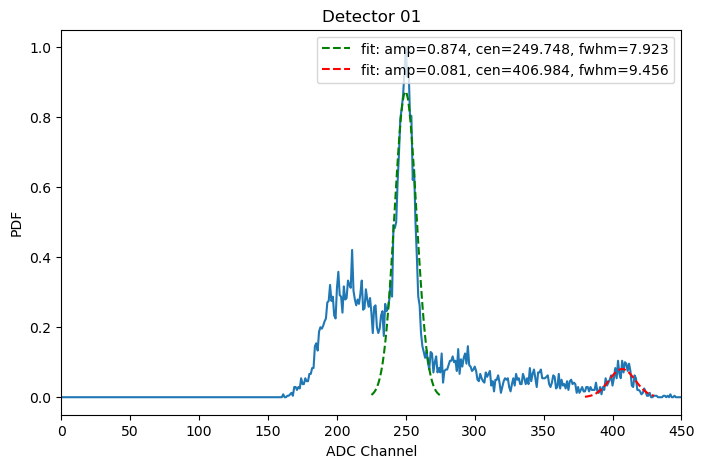

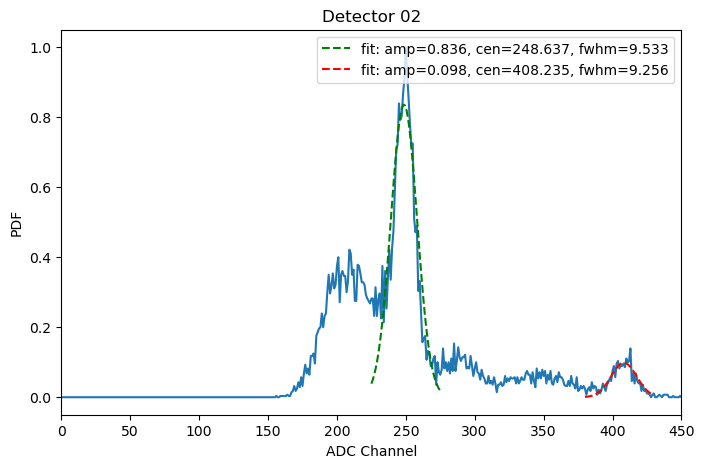

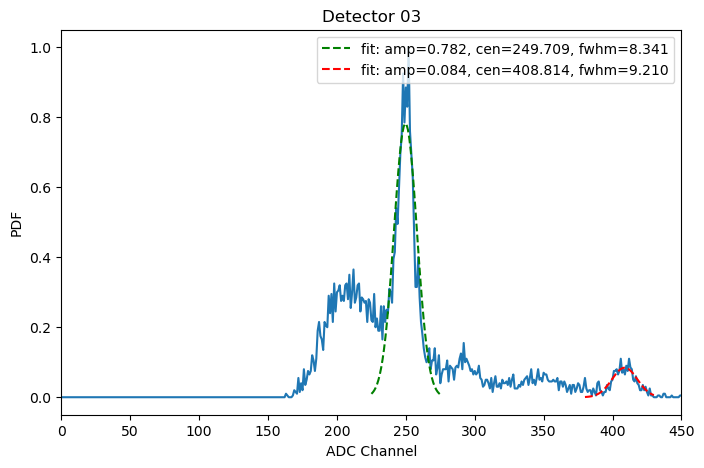

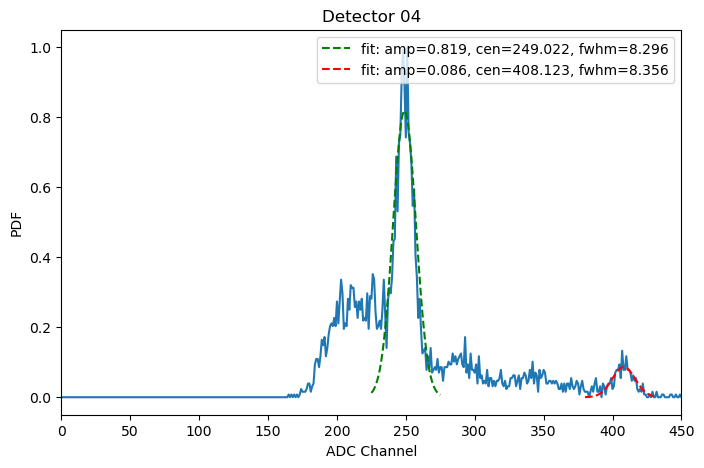

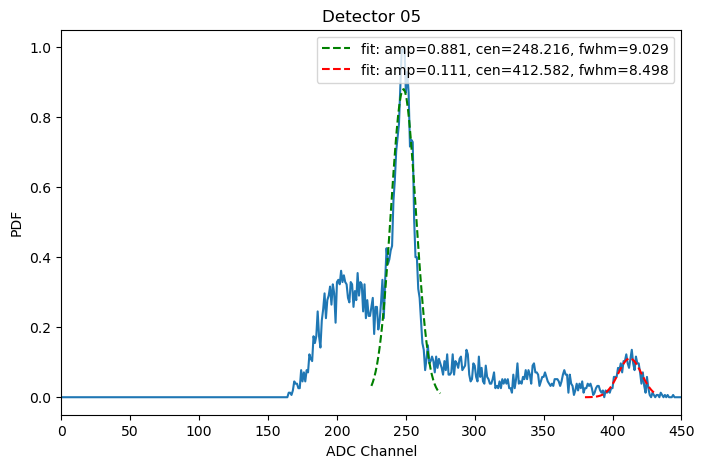

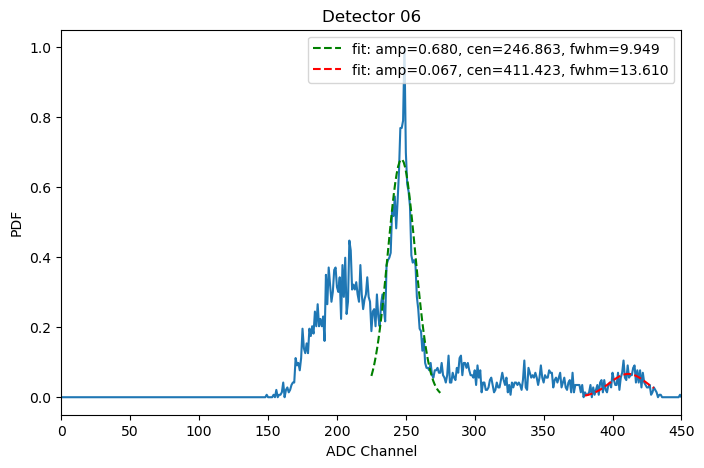

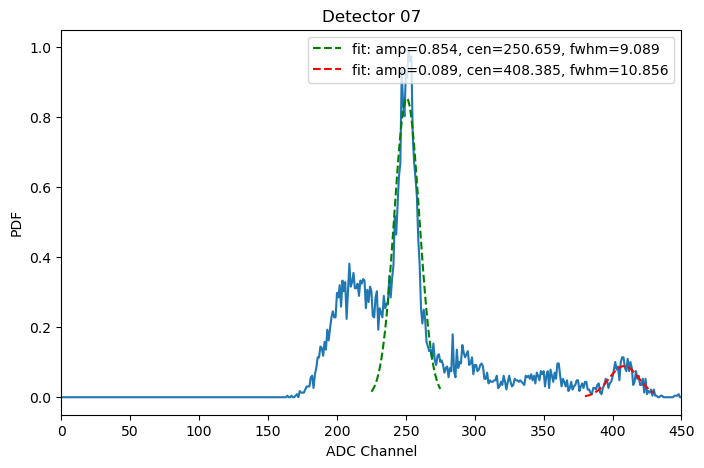

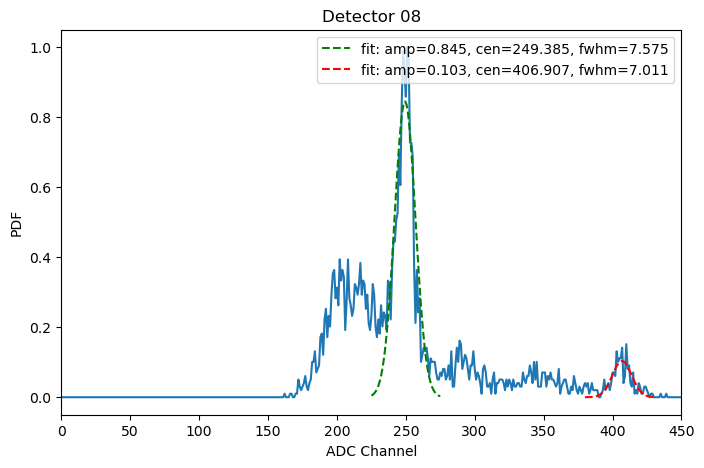

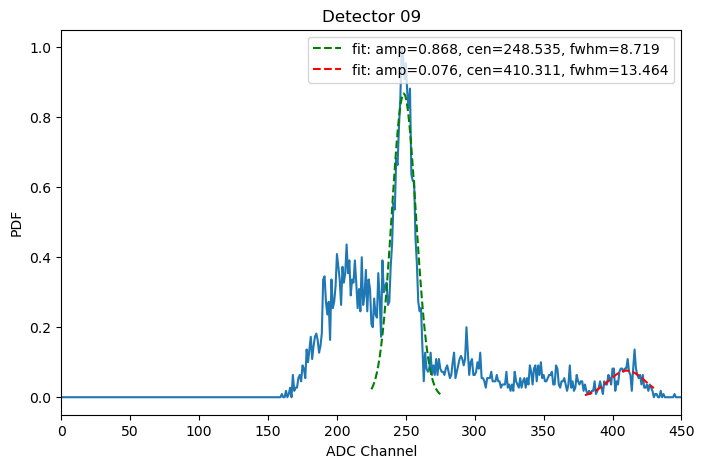

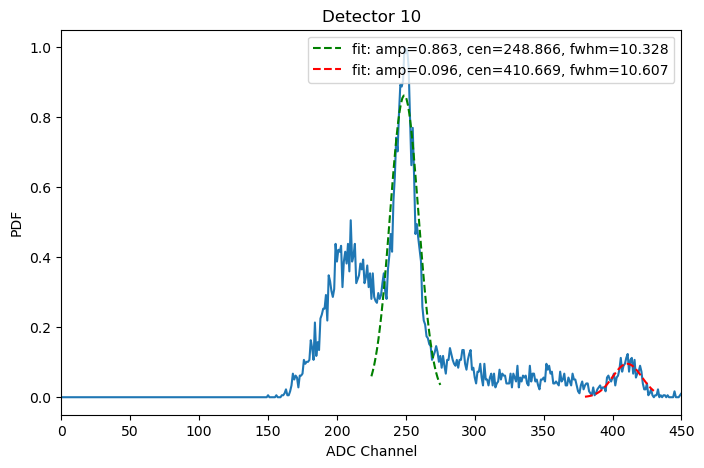

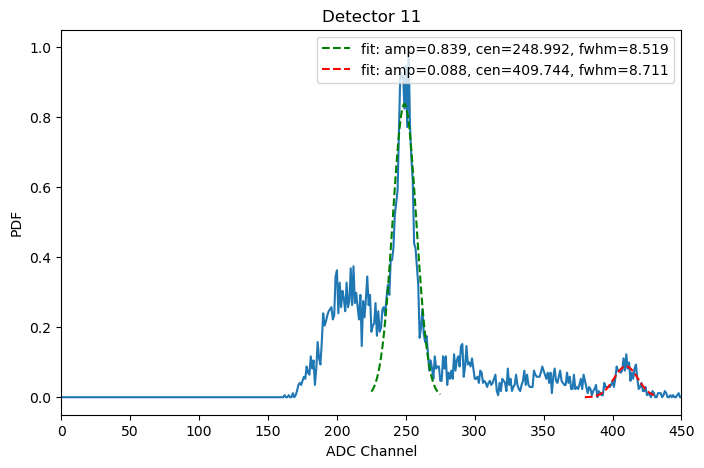

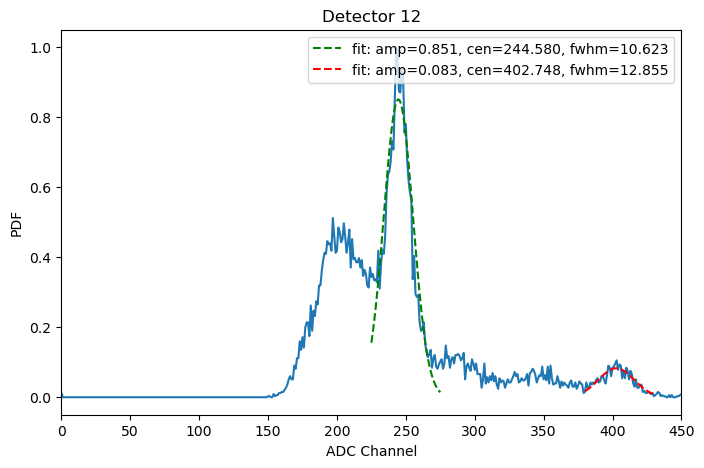

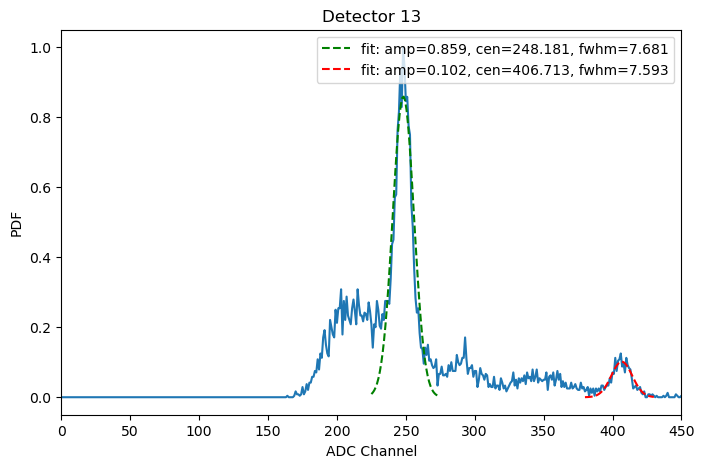

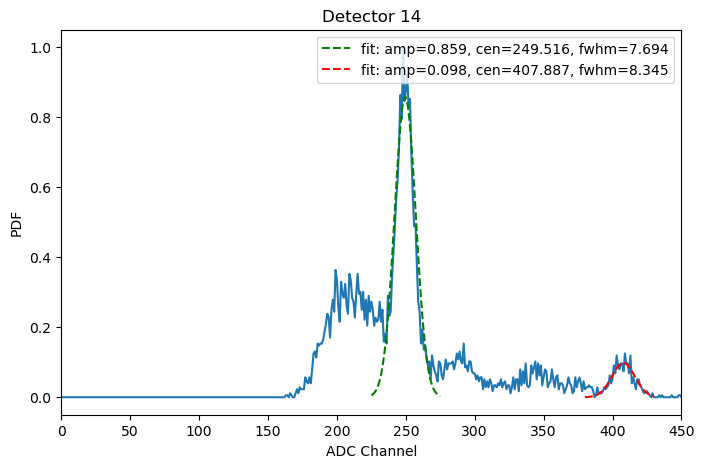

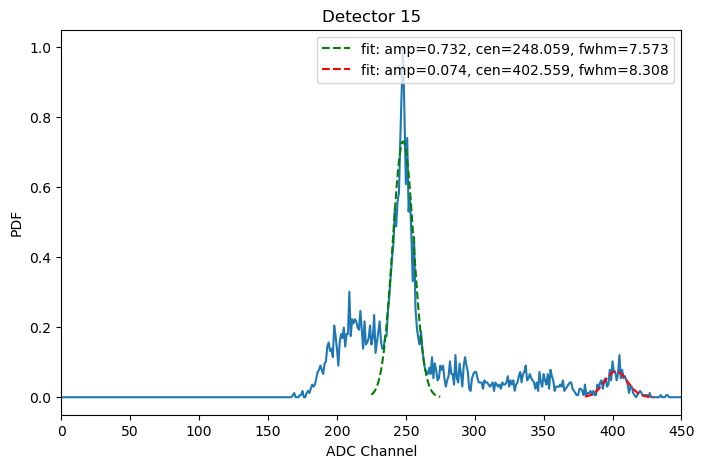

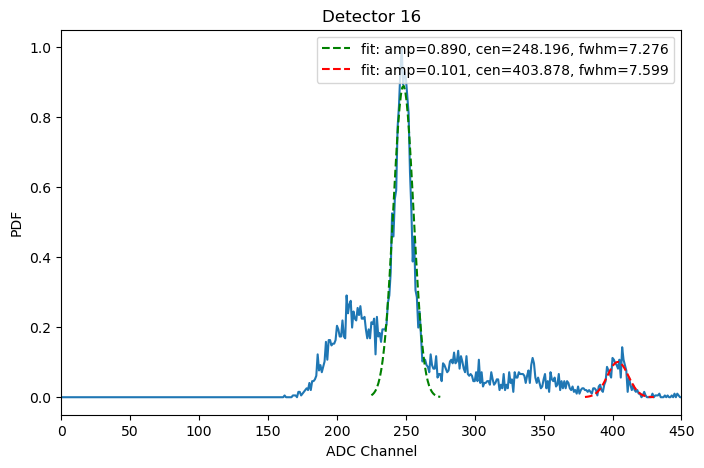

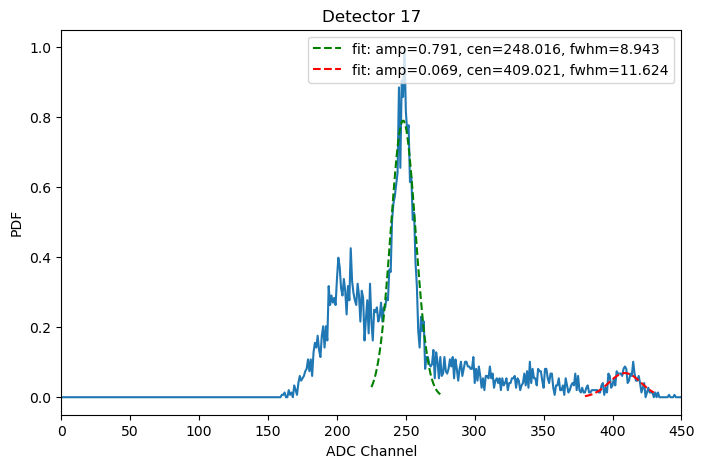

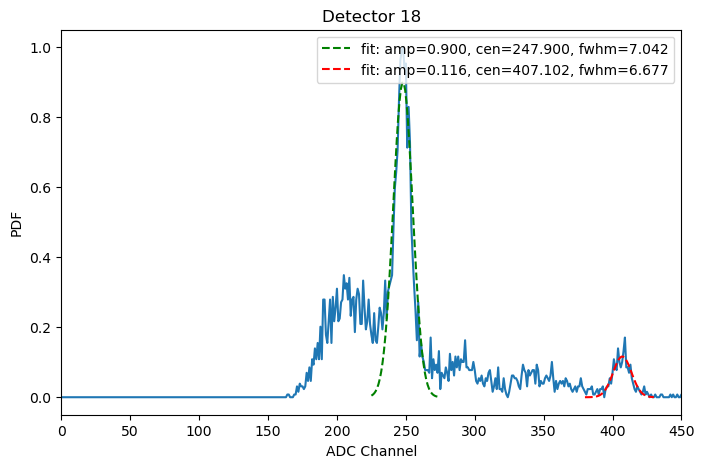

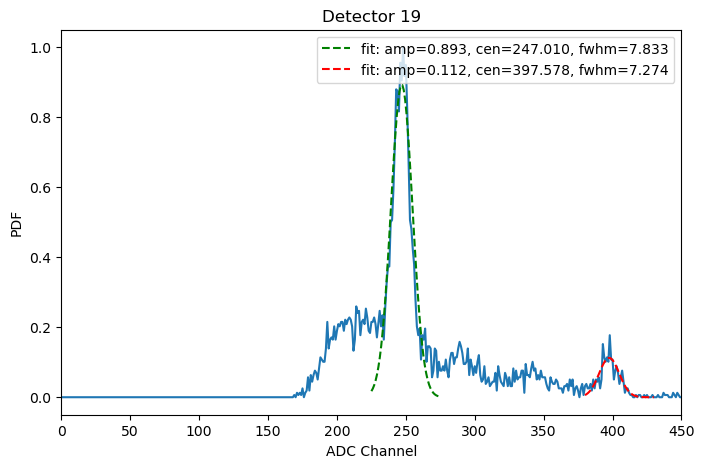

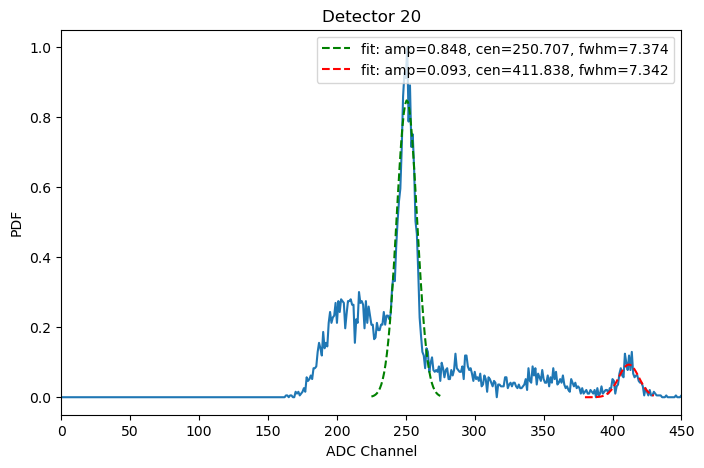

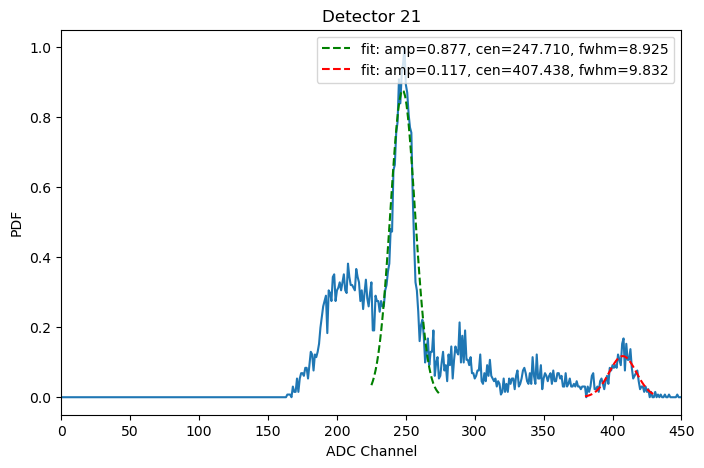

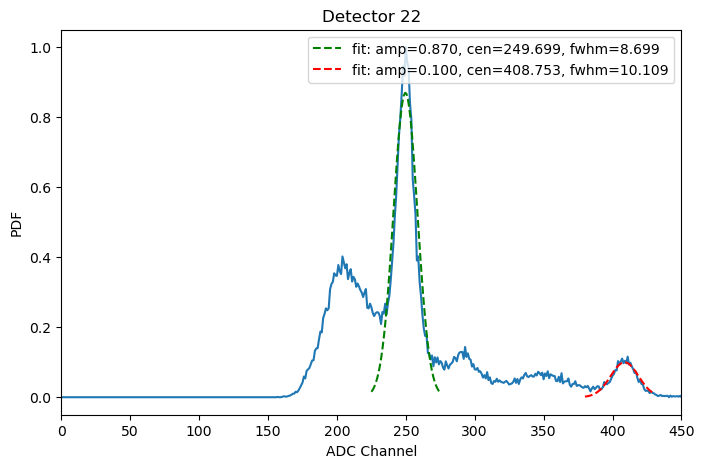

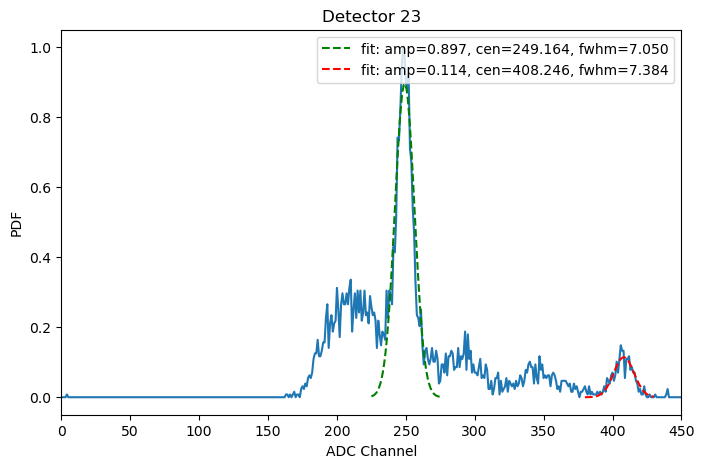

In [8]:
# Read in data from ROOT files and plot

directory = os.fsencode("Bknd_Calibration")

######################################################################################################
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Bknd_Calibration/" + filename

    detNames.append(filename[3:5])
    
    with uproot.open(datafile) as file:

        bknd = file["Energy/_F_EnergyCH0@DT5751_626"]
        bkndData,bins = bknd.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        bkndNorm = (bkndData - bkndData.min())/ (bkndData.max() - bkndData.min())   # Normalize since inconsistent counts

        bins1 = np.linspace(225,275,50)
        bins2 = np.linspace(380,430,50)

        ######################################################################################################

        popt1, pcov1 = curve_fit(Gauss,bins1,bkndNorm[225:275],p0=[1.0,250,6])   # Estimate paramters from initial guess
        popt2, pcov2 = curve_fit(Gauss,bins2,bkndNorm[380:430],p0=[0.1,415,8])   # Estimate paramters from initial guess

        bestFit1 = Gauss(bins1,popt1[0],popt1[1],popt1[2])   # Compute the best fit using estimated parameters
        bestFit2 = Gauss(bins2,popt2[0],popt2[1],popt2[2])   # Compute the best fit using estimated parameters

        perr1 = np.sqrt(np.diag(pcov1))   # Calculate error from covariance matrix of estimated parameters
        perr2 = np.sqrt(np.diag(pcov2))   # Calculate error from covariance matrix of estimated parameters

        ######################################################################################################

        amp1.append(popt1[0])
        amp1err.append(perr1[0])
        cen1.append(popt1[1])
        cen1err.append(perr1[1])
        fwhm1.append(popt1[2])
        fwhm1err.append(perr1[2])
        
        amp2.append(popt2[0])
        amp2err.append(perr2[0])
        cen2.append(popt2[1])
        cen2err.append(perr2[1])
        fwhm2.append(popt2[2])
        fwhm2err.append(perr2[2])

        ######################################################################################################

        PlotFit(filename,bins,bkndNorm,bins1,bestFit1,bins2,bestFit2,popt1,popt2)

        ######################################################################################################

# Save the fit parameters and uncertainty to .csv file 

SaveFit('bkndCalParams.csv',detNames,amp1,amp1err,cen1,cen1err,
            fwhm1,fwhm1err,amp2,amp2err,cen2,cen2err,fwhm2,fwhm2err)


### Na-22 Calibration

In [9]:
# Create arrays to store parameters while looping through data files

detNames,amp1,amp1err,cen1,cen1err,fwhm1,fwhm1err,amp2,amp2err,cen2,cen2err,fwhm2,fwhm2err = CreateArrays()


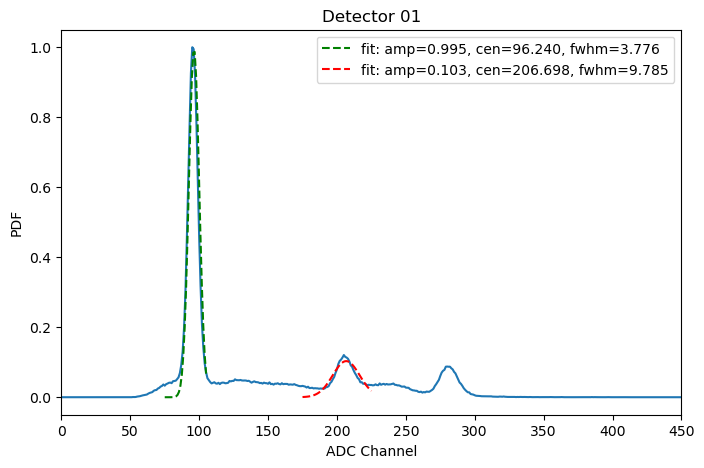

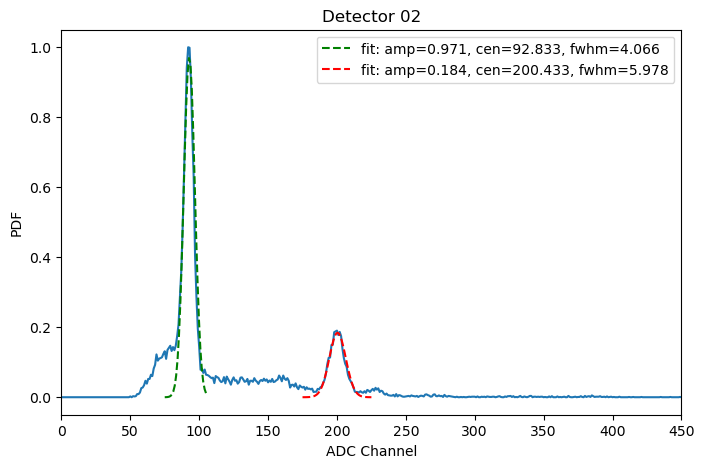

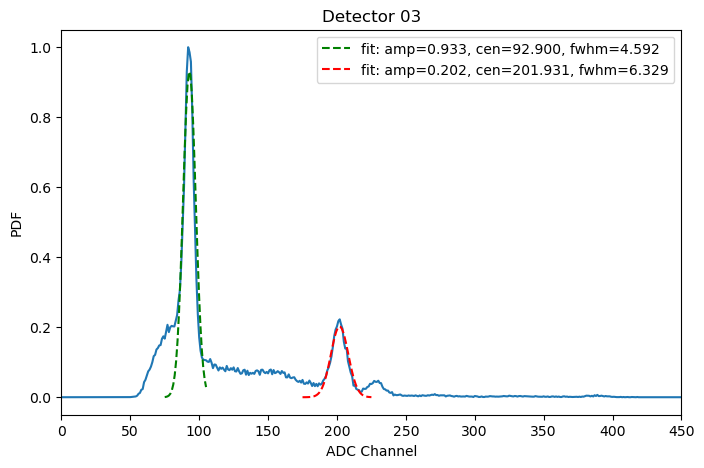

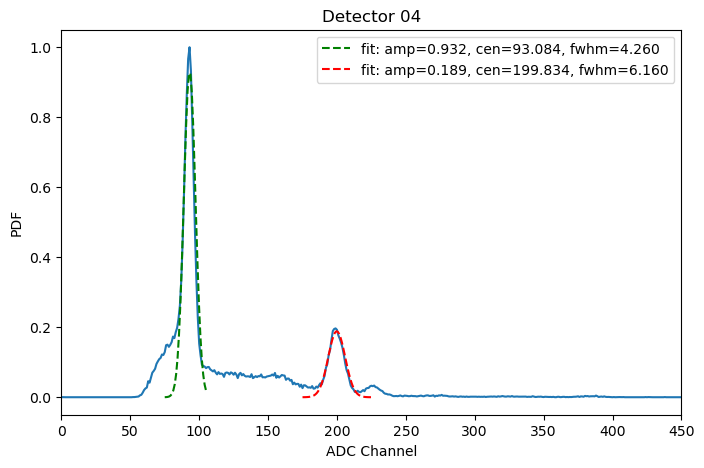

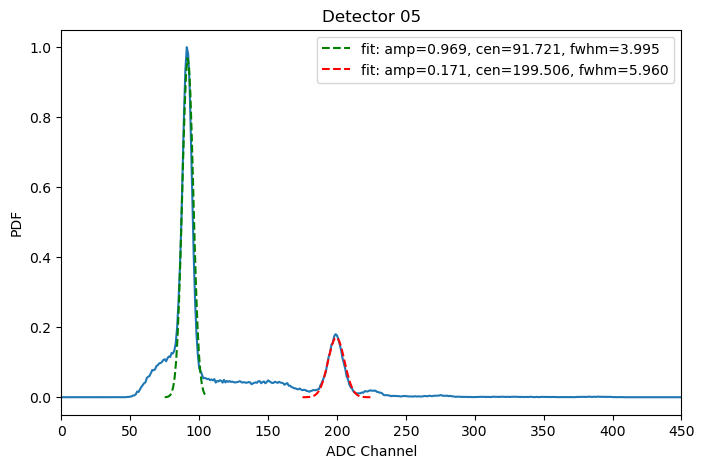

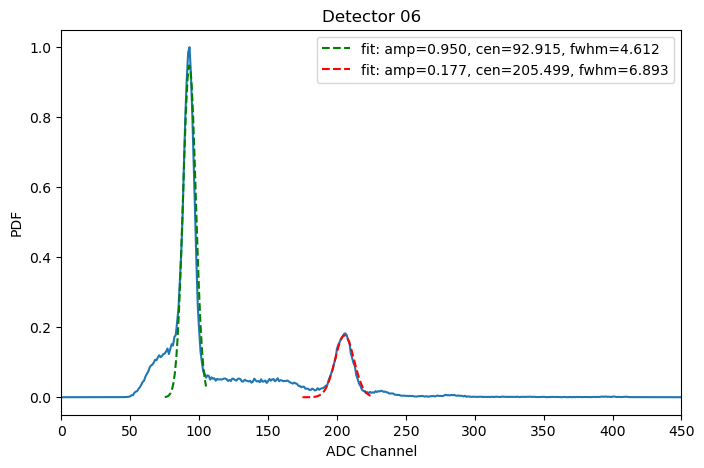

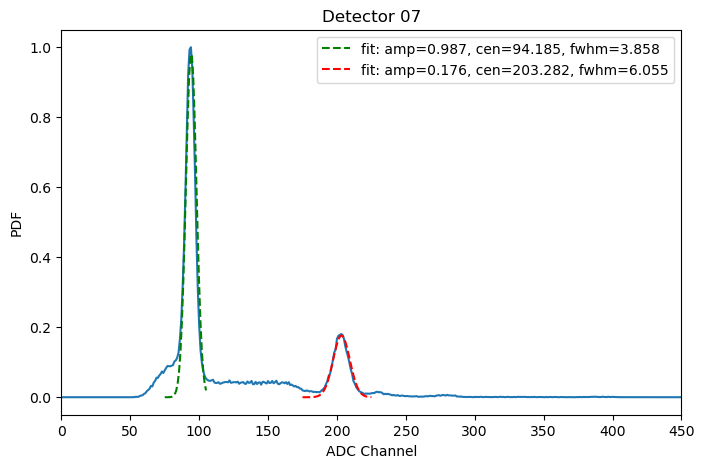

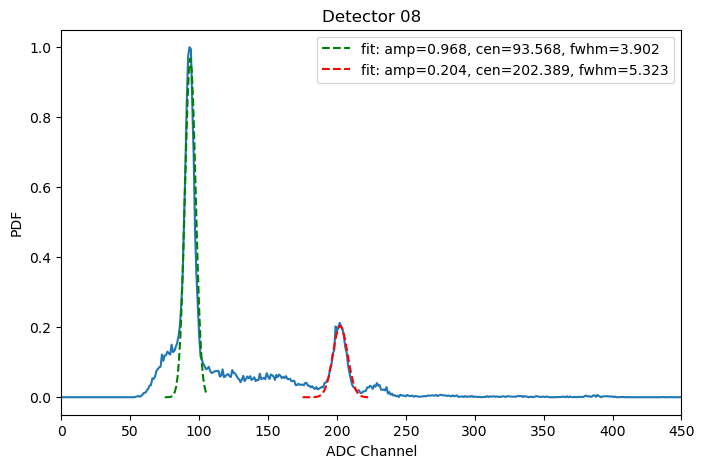

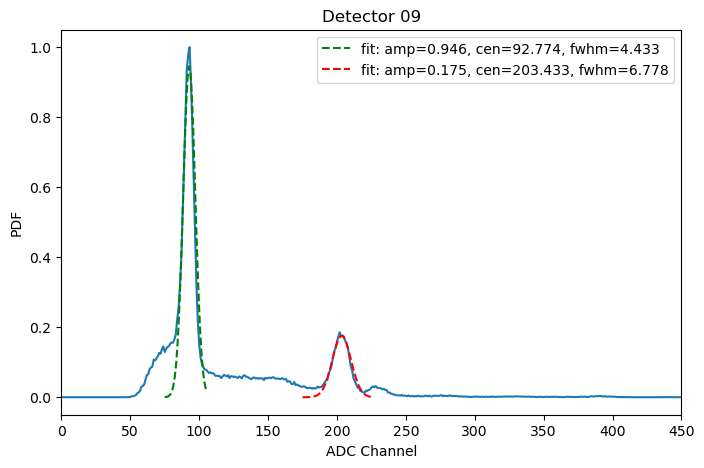

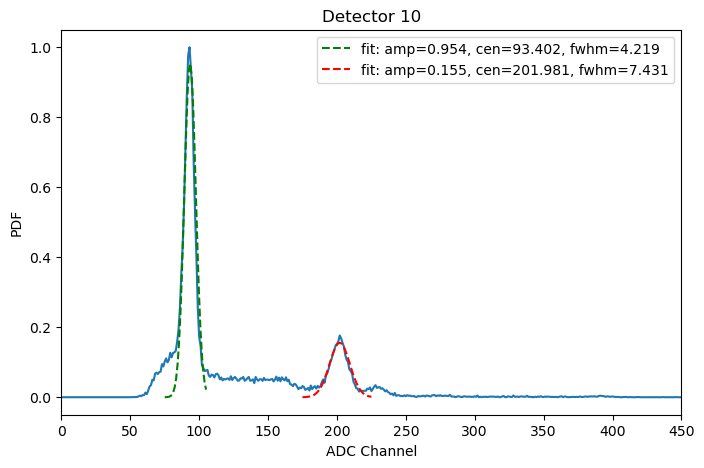

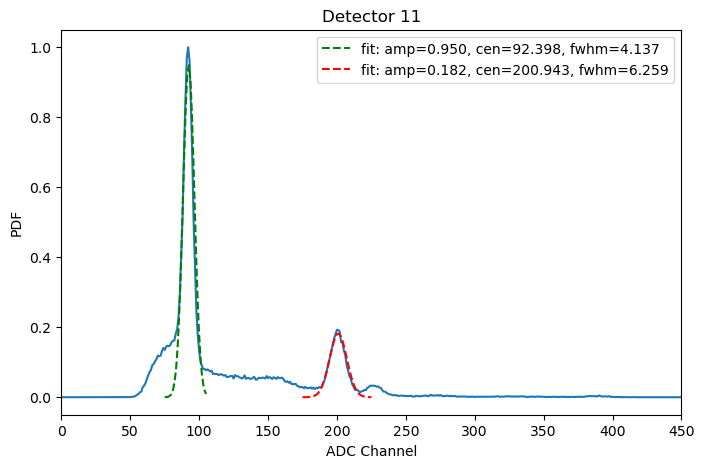

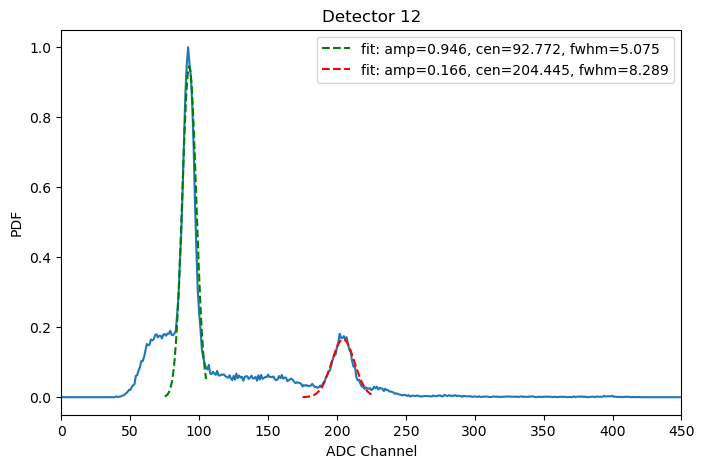

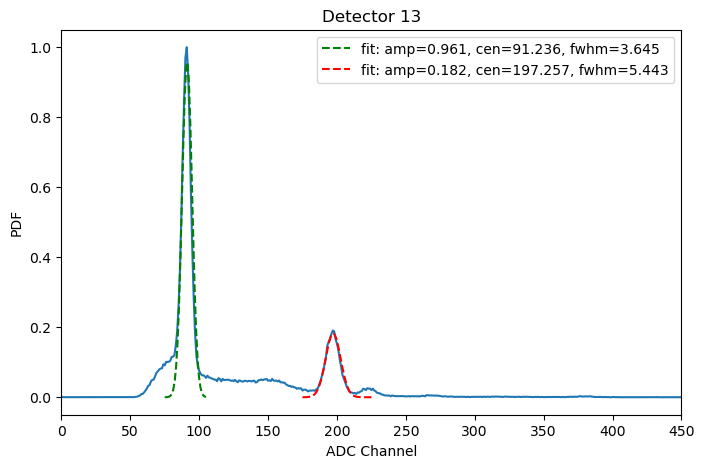

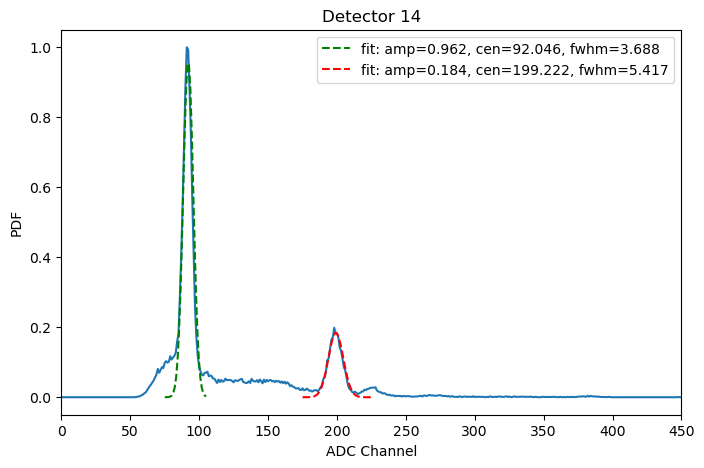

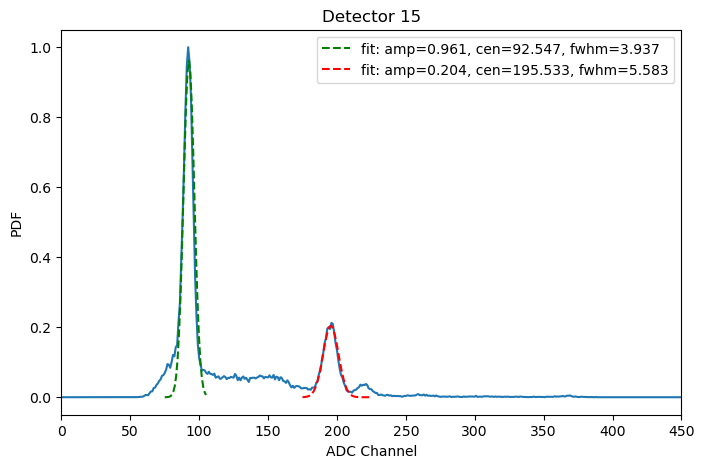

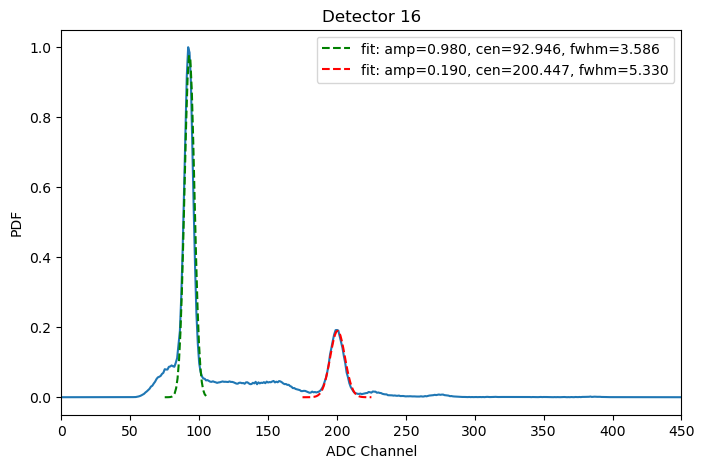

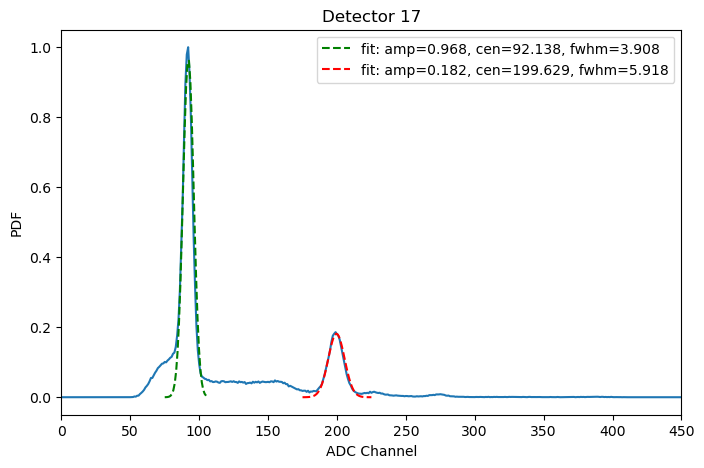

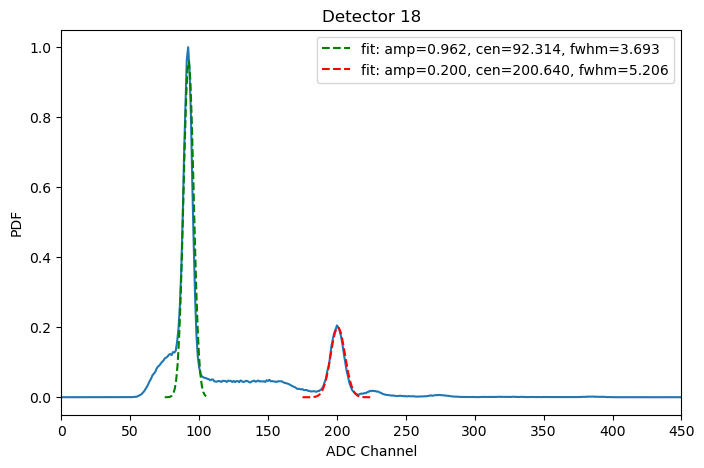

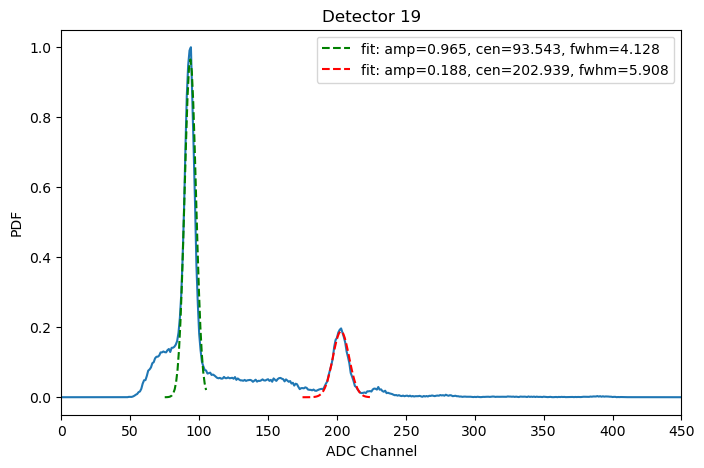

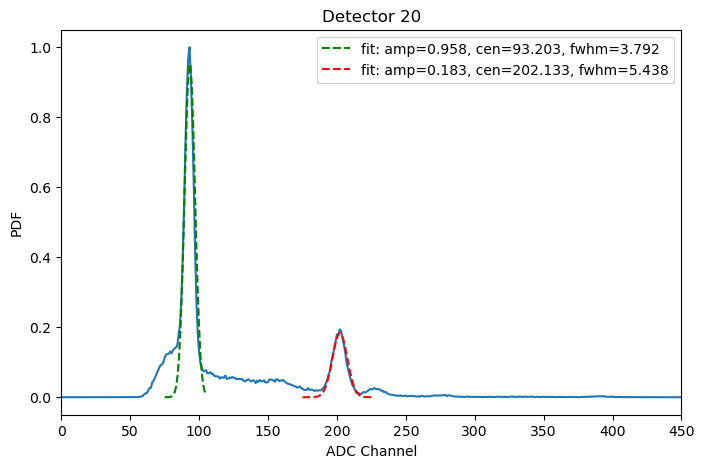

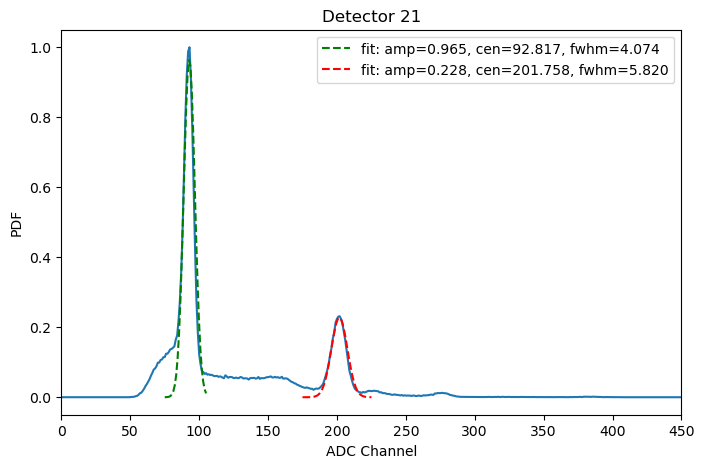

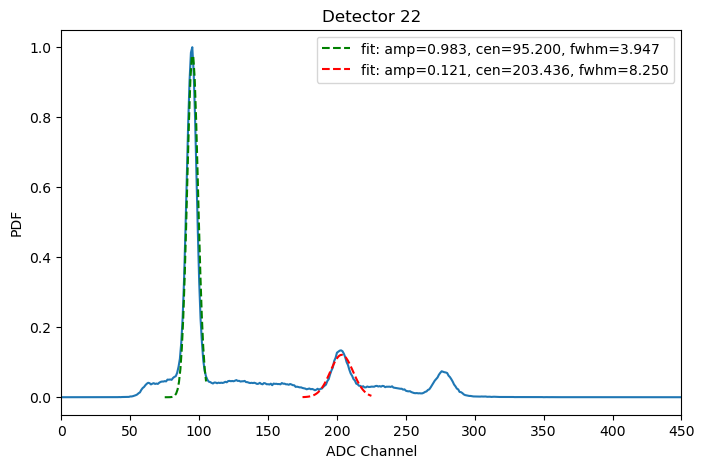

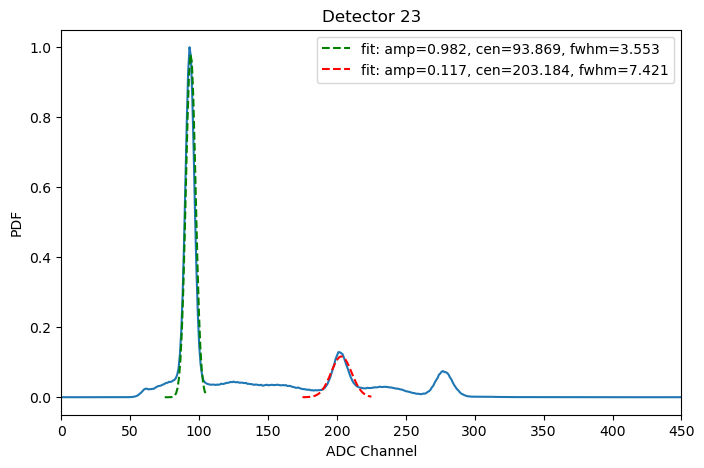

In [10]:
# Read in data from ROOT files and plot

directory = os.fsencode("Na22_Calibration")

######################################################################################################
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Na22_Calibration/" + filename

    detNames.append(filename[3:5])
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        Na22 = file["Energy/_F_EnergyCH0@DT5751_626"]
        Na22Data,bins = Na22.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        Na22Norm = (Na22Data - Na22Data.min())/ (Na22Data.max() - Na22Data.min())   # Normalize since inconsistent counts
        
        #PlotHist(filename,Na22Norm,bins)

        bins1 = np.linspace(75,105,30)
        bins2 = np.linspace(175,225,50)

        ######################################################################################################

        popt1, pcov1 = curve_fit(Gauss,bins1,Na22Norm[75:105],p0=[1,92,3])
        popt2, pcov2 = curve_fit(Gauss,bins2,Na22Norm[175:225],p0=[0.2,200,6])
        
        bestFit1 = Gauss(bins1,popt1[0],popt1[1],popt1[2])
        bestFit2 = Gauss(bins2,popt2[0],popt2[1],popt2[2])

        perr1 = np.sqrt(np.diag(pcov1))
        perr2 = np.sqrt(np.diag(pcov2))
        
        ######################################################################################################

        amp1.append(popt1[0])
        amp1err.append(perr1[0])
        cen1.append(popt1[1])
        cen1err.append(perr1[1])
        fwhm1.append(popt1[2])
        fwhm1err.append(perr1[2])
        
        amp2.append(popt2[0])
        amp2err.append(perr2[0])
        cen2.append(popt2[1])
        cen2err.append(perr2[1])
        fwhm2.append(popt2[2])
        fwhm2err.append(perr2[2])

        ######################################################################################################
        
        PlotFit(filename,bins,Na22Norm,bins1,bestFit1,bins2,bestFit2,popt1,popt2)
        
        ######################################################################################################

# Save the fit parameters and uncertainty to .csv file 

SaveFit('Na22CalParams.csv',detNames,amp1,amp1err,cen1,cen1err,
            fwhm1,fwhm1err,amp2,amp2err,cen2,cen2err,fwhm2,fwhm2err)


### Extra Fitting Code for Manual Fits or More Accurate Lmfit (couldn't quite get working)

    ##################################
    #        MANUAL FITTING
    ##################################
    
    bestFit1 = Gauss(bins1,1,250,6)   # Fit the channel 250 peak
    bestFit2 = Gauss(bins2,0.1,415,8)   # Fit the channel 400 peak
    
    ##################################
    #        LMFIT FITTING
    ################################### 
    
    # Define function for fitting peaks to a Gaussian distrubution
    
    def FitHist(data,bins,cen,amp,yint,slp):
    
        peak = GaussianModel()
        background = LinearModel()
        mod = peak + background
    
        counts, bin_edges = np.histogram(data,bins=bins)
        bin_widths = np.diff(bin_edges)
        x = bin_edges[:-1] + (bin_widths/2)
        y = counts
        
        #pars = background.make_params(intercept=yint,slope=slp)
        pars = background.guess(y,x=x,intercept=yint,slope=slp)
        pars += peak.guess(y,x=x,center=cen,amplitude=amp)
        final_fit = mod.fit(y,pars,x=x)
        #final_fit.plot_fit()
       
        center = final_fit.params['center'].value
        #center_err = final_fit.params['center'].stderr
        width = final_fit.params['fwhm'].value
        #width_err = final_fit.params['fwhm'].stderr
    
        return final_fit   # bins,center,width
    
    # Implement function
    
    fit1 = FitHist(bkndData[225:275],bins1,250,1,0.3,-1)
    fit2 = FitHist(bkndData[380:430],bins2,415,0.1,0,0)
    
    print(fit1.fit_report())
    
    bestFit1 = fit1.best_fit
    bestFit2 = fit2.best_fit
    
    bins1 = bins1[:-1]
    bins2 = bins2[:-1]
    
    bestFit1 = fit1.best_fit/np.sum(fit1.best_fit)/np.diff(bins1)[0]
    bestFit2 = fit2.best_fit/np.sum(fit2.best_fit)/np.diff(bins2)[0]
